In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'serif', 'figure.figsize': (12, 6)})
from scipy.optimize import curve_fit

# read in data
header = ["voltage","current"]
raw_data = np.genfromtxt('diode-data.csv', delimiter=',', skip_header=1, names=header)
voltage = raw_data["voltage"]
current = raw_data["current"]

# Uncertainties
# For negative V, we have 0.00001 as the least significant digit, and 0.001 or 0.01 for the positive voltages.
# I will do each of the ranges seperately based on the multimeter manual.
current_neg_voltage = np.array(current[voltage <= 0])
current_pos_voltage = np.array(current[voltage > 0])

def uncertainty(current,digits):
    return 0.002*current + 5*digits
current_unc = np.concatenate((
    uncertainty(current_neg_voltage,0.00001),
    uncertainty(current_pos_voltage[:3],0.001),
    uncertainty(current_pos_voltage[3:],0.01)
    ))

# sort data by voltage 
sort_index = np.argsort(voltage)
voltage = voltage[sort_index]*1000 # mV
current = current[sort_index]
current_unc = current_unc[sort_index]


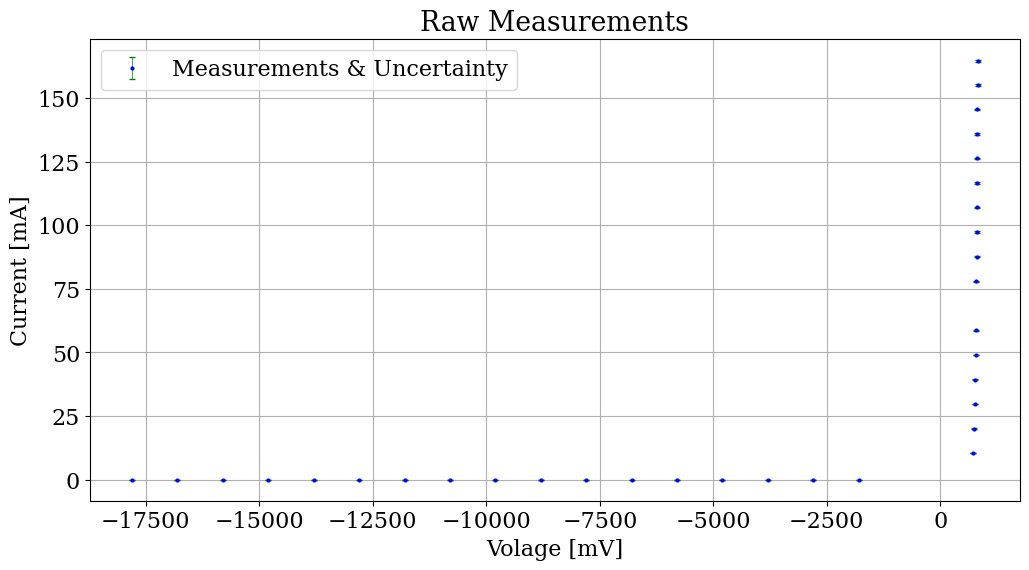

In [14]:
# plot raw data
fig = plt.figure()
plt.title("Raw Measurements")
plt.errorbar(voltage, current, fmt="o", c="blue",ecolor="green", capsize=2, yerr=current_unc, markersize=2, lw=0.5, label="Measurements & Uncertainty")
plt.xlabel("Volage [mV]")
plt.ylabel("Current [mA]")
plt.grid()
plt.legend()
fig.savefig("raw_data.pdf")

I(V) = I_s * (exp(V/V_T) - 1)
I_s = 1.9308277718764813e-07 +/- 3.019662432166514e-09 mA
V_T = 32.483058831885444 +/- 3.703673372130766e-05 mV
eta = 1.2334738971970522 +/- 0.0009753480855724743


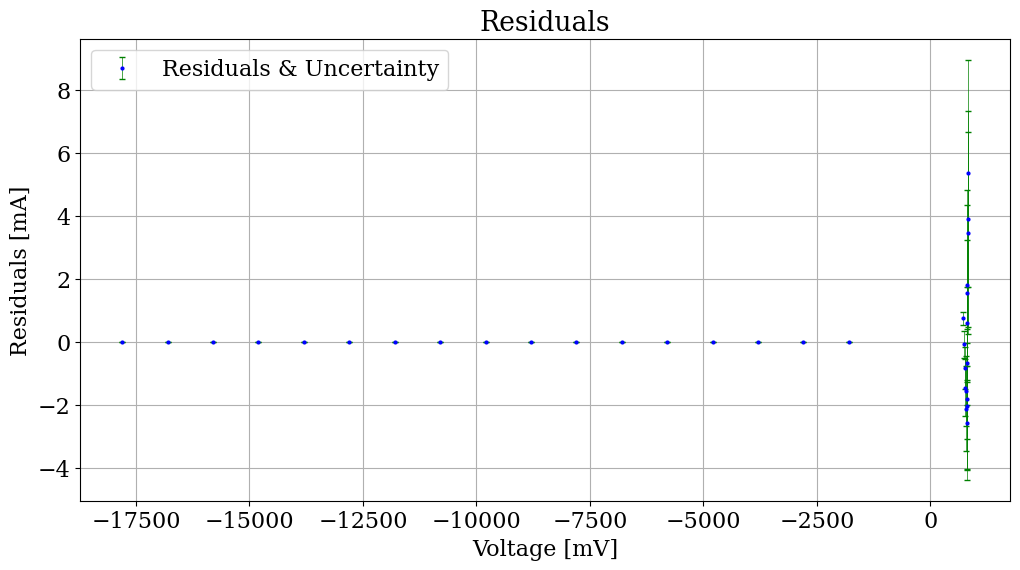

In [15]:
def shockley(V, I_s, V_T, eta):
    return I_s * (np.exp(V / (eta*V_T)) - 1)
popt, pcov = curve_fit(shockley, voltage, current, p0=[0.0025,26,1], bounds=[[0,20,1],[0.1,40,3]], sigma=current_unc, absolute_sigma=True)
param_unc = np.sqrt(np.diag(pcov))
residuals = current - shockley(voltage,*popt)

def model_uncertainty(V):
    return np.sqrt(
        param_unc[0]**2*(np.exp(V/(popt[1]*popt[2]))-1)**2 +
        V**2*popt[0]**2*np.exp(2*V/(popt[1]*popt[2]))*((param_unc[1]/(popt[1]**2*popt[2]))**2 + (param_unc[2]/(popt[1]*popt[2]**2))**2)
    )

residual_unc = np.sqrt(current_unc**2 + model_uncertainty(voltage)**2)

plt.title("Residuals")
plt.errorbar(voltage, residuals, fmt="o", c="blue",ecolor="green", capsize=2, yerr=residual_unc, markersize=2, lw=0.5, label="Residuals & Uncertainty")
plt.xlabel("Voltage [mV]")
plt.ylabel("Residuals [mA]")
plt.grid()
plt.legend()
#plt.savefig("residuals.pdf")

print("I(V) = I_s * (exp(V/V_T) - 1)")
print(f"I_s = {popt[0]} +/- {param_unc[0]} mA")
print(f"V_T = {popt[1]} +/- {param_unc[1]} mV")
print(f"eta = {popt[2]} +/- {param_unc[2]}")

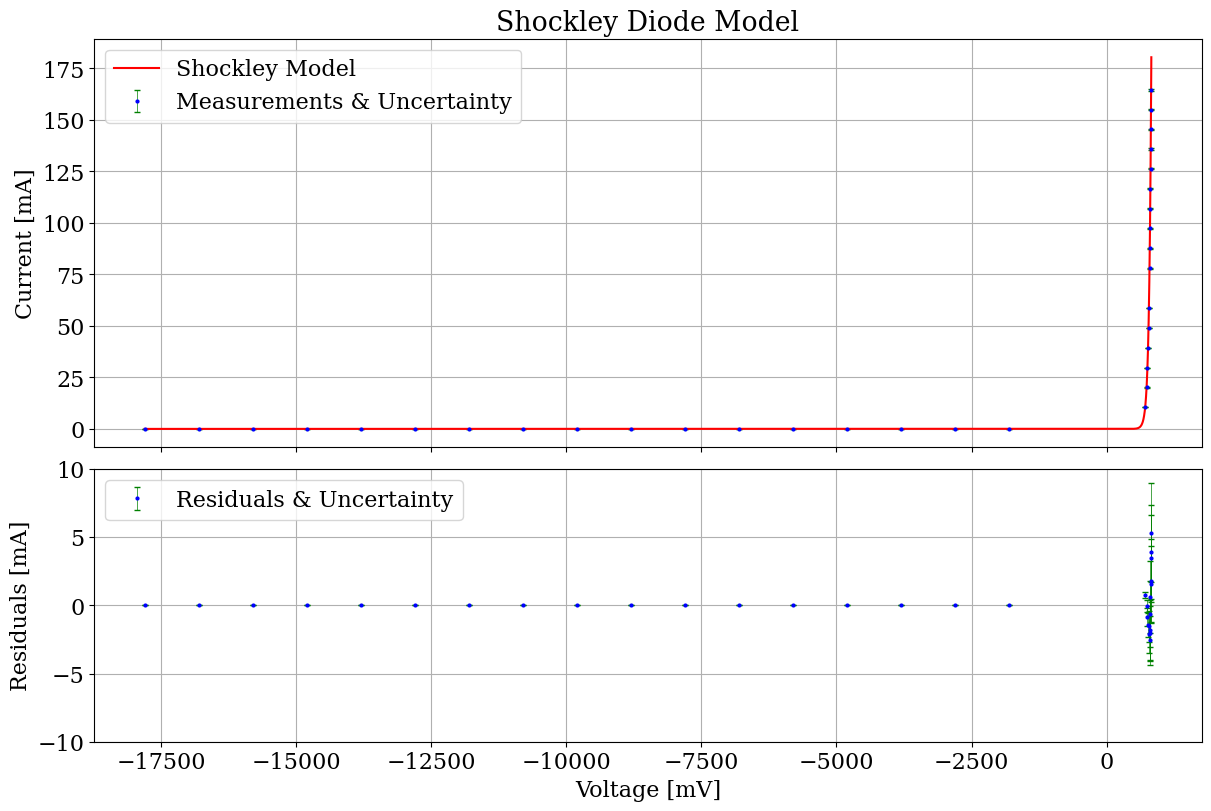

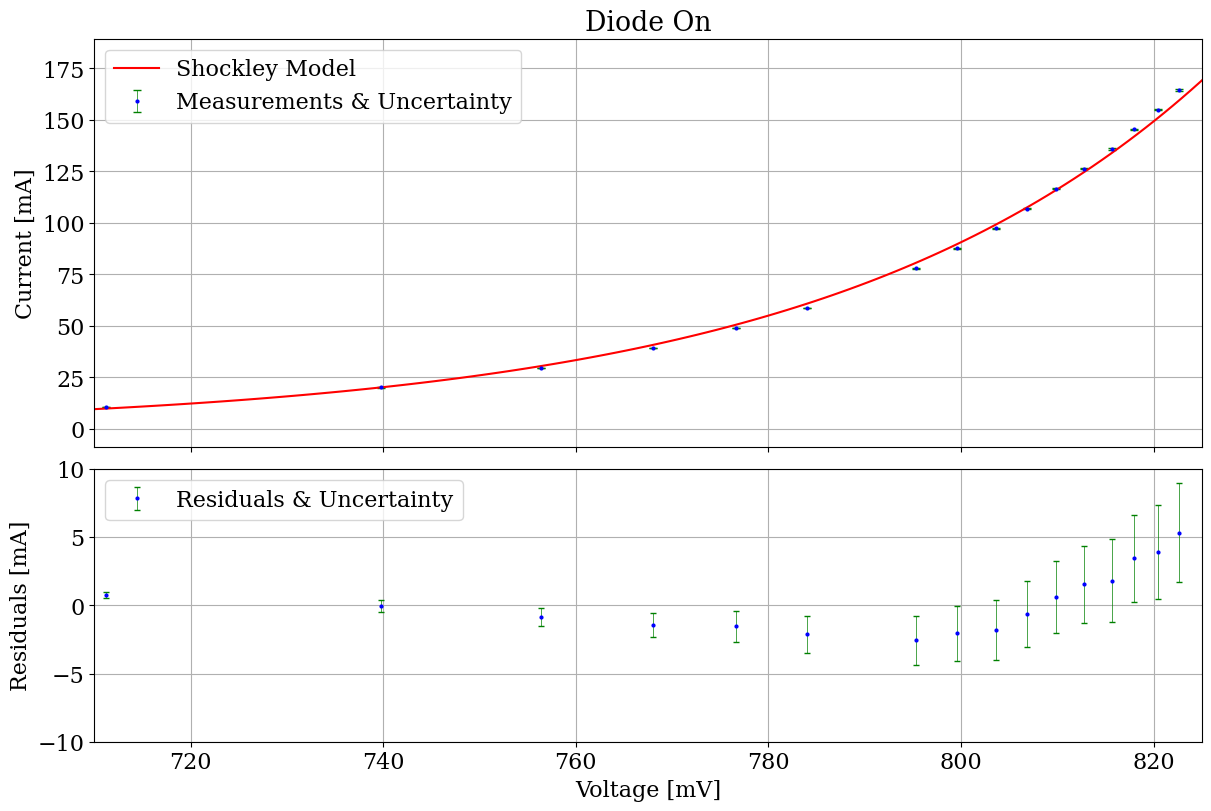

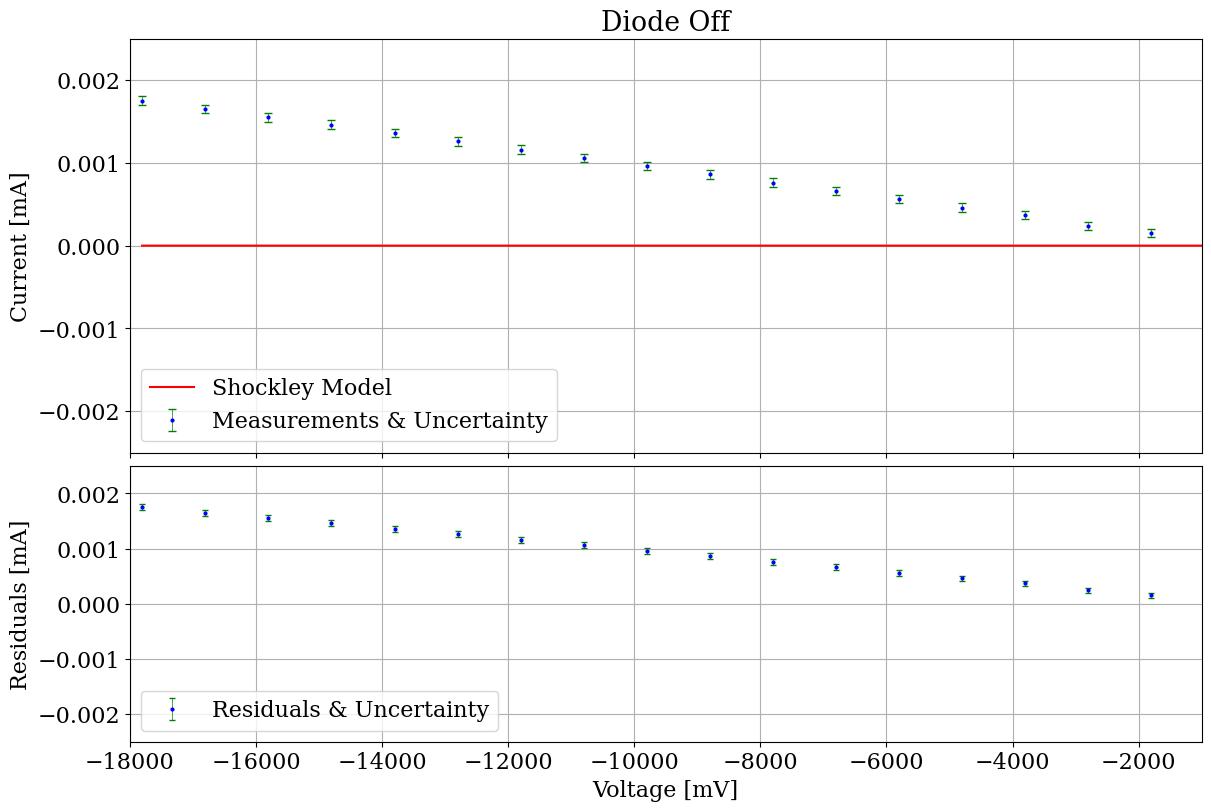

In [16]:
model_voltages = np.linspace(np.min(voltage)-5, np.max(voltage)+5, 20000)

fig, axs = plt.subplots(2,1,layout="constrained",gridspec_kw={'height_ratios': [3, 2]},sharex=True,figsize=(12,8))
axs[0].set_title("Shockley Diode Model")
axs[0].errorbar(voltage, current, label="Measurements & Uncertainty",fmt="o", c="blue",ecolor="green", capsize=2, yerr=current_unc, markersize=2, lw=0.5)
axs[0].plot(model_voltages, shockley(model_voltages, *popt), label="Shockley Model", color="red")
axs[0].set_ylabel("Current [mA]")
axs[0].grid()
axs[0].legend()
axs[1].set_ylim(-10,10)
axs[1].errorbar(voltage, residuals, fmt="o", c="blue",ecolor="green", capsize=2, yerr=residual_unc, markersize=2, lw=0.5, label="Residuals & Uncertainty")
axs[1].grid()
axs[1].legend()
axs[1].set_xlabel("Voltage [mV]")
axs[1].set_ylabel("Residuals [mA]")
fig.savefig("shockley_model.pdf")

fig, axs = plt.subplots(2,1,layout="constrained",gridspec_kw={'height_ratios': [3, 2]},sharex=True,figsize=(12,8))
axs[0].set_xlim(710, 825)
axs[1].set_xlim(710, 825)
axs[0].set_title("Diode On")
axs[0].errorbar(voltage, current, label="Measurements & Uncertainty",fmt="o", c="blue",ecolor="green", capsize=3, yerr=current_unc, markersize=2, lw=0.5)
axs[0].plot(model_voltages, shockley(model_voltages, *popt), label="Shockley Model", color="red")
axs[0].set_ylabel("Current [mA]")
axs[0].grid()
axs[0].legend()
axs[1].set_ylim(-10,10)
axs[1].errorbar(voltage, residuals, fmt="o", c="blue",ecolor="green", capsize=2, yerr=residual_unc, markersize=2, lw=0.5, label="Residuals & Uncertainty")
axs[1].grid()
axs[1].legend()
axs[1].set_xlabel("Voltage [mV]")
axs[1].set_ylabel("Residuals [mA]")
fig.savefig("diode_on.pdf")


fig, axs = plt.subplots(2,1,layout="constrained",gridspec_kw={'height_ratios': [3, 2]},sharex=True,figsize=(12,8))
axs[0].set_xlim(-18000, -1000)
axs[0].set_ylim(-0.0025,0.0025)
axs[1].set_xlim(-18000, -1000)
axs[1].set_ylim(-0.0025,0.0025)
axs[0].set_title("Diode Off")
axs[0].errorbar(voltage, current, label="Measurements & Uncertainty",fmt="o", c="blue",ecolor="green", capsize=3, yerr=current_unc, markersize=2, lw=0.5)
axs[0].plot(model_voltages, shockley(model_voltages, *popt), label="Shockley Model", color="red")
axs[0].set_ylabel("Current [mA]")
axs[0].grid()
axs[0].legend()
axs[1].errorbar(voltage, residuals, fmt="o", c="blue",ecolor="green", capsize=2, yerr=residual_unc, markersize=2, lw=0.5, label="Residuals & Uncertainty")
axs[1].grid()
axs[1].legend()
axs[1].set_xlabel("Voltage [mV]")
axs[1].set_ylabel("Residuals [mA]")
fig.savefig("diode_off.pdf")